# NLP X - HEC Embeddings Part 2 : Advanced Representations


In this practical session, we will focus on word embeddings through word2vec, a simple and more advanced classification models for sentiment analysis (reviews ratings prediction). Once a negative sampling word2vec skipgram is trained, we can visualize learned word vectors in a reduced space and use them in our classification model.

You will be asked to :
1. **Train your own word embeddings with Skipgram** and Tensorflow using **Negative Sampling** method
2. **Train a sentiment model** using your pre-trained word embeddings as inputs for a simple classification architecture
3. **Upgrade your sentiment model with attention mechanism** through a Hierarchical Attention Network (HAN)
4. **Visualize attention weights** to interpret main sentences and words involved in the prediction


In [1]:
import io
import os
import re
import tqdm
import warnings
import itertools
from ast import literal_eval

import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px

import nltk
import sklearn
from sklearn import decomposition
import tensorflow as tf

nltk.download("punkt")
warnings.filterwarnings('ignore')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [2]:
tqdm.tqdm_notebook()
tqdm.notebook.tqdm().pandas()

### Data collection and preprocessing

In [3]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
dirpath = "drive/MyDrive/Capgemini/X-HEC - 2021/" # change the directory path here
filepath = os.path.join(dirpath, "clean_text_scrapped_data_2021.csv.gz")

DATASET_SIZE = 50000
def get_reviews(nrows=None):
    return pd.read_csv(filepath,
                     compression='gzip', 
                     low_memory=False, 
                     nrows=nrows,
                     parse_dates=['diner_date', 'rating_date'])


def clean_reviews(reviews):
    reviews['review'] = reviews.content.apply(lambda x: ' '.join(eval(x)))
    return reviews


def split_reviews_per_sentence(reviews):
    reviews["review_sentences"] = reviews.review.progress_apply(
        lambda rvw: nltk.sent_tokenize(rvw)
    )
    return reviews

In [5]:
reviews = get_reviews(DATASET_SIZE)
reviews.head(2)

Unnamed: 0  ...                                      clean_content
0      482202  ...  ["'we", 'actually', 'visited', 'place', 'time'...
1      482231  ...  ['blast', 'warm', 'air', 'greeted', 'u', 'ente...

[2 rows x 20 columns]

In [6]:
reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 20 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   Unnamed: 0              50000 non-null  int64         
 1   0                       0 non-null      float64       
 2   answer_text             50000 non-null  object        
 3   content                 50000 non-null  object        
 4   diner_date              49064 non-null  datetime64[ns]
 5   id_comment              50000 non-null  object        
 6   id_resto                50000 non-null  object        
 7   other_ratings_category  50000 non-null  object        
 8   other_ratings_value     50000 non-null  object        
 9   rating                  50000 non-null  float64       
 10  rating_date             50000 non-null  datetime64[ns]
 11  resto                   50000 non-null  object        
 12  resto_url               50000 non-null  object

### Preprocessing & Understanding

Let's visualize a review, contained in `content` column, then perform basic cleaning to get a proper text for each review

In [7]:
reviews.content[0], type(reviews.content[0])

('[\'We actually visited this place a few times for lunch since it opened and it was fine. Good food, and staff are nice. \', \'We then got take away and it was awful. Late, cold, and trying to resolve the problem meant seven or eight phone calls before they finally refunded 50%. Pretty disappointing as we live locally and have always recommended it to friends etc. \', "Wood street needed a nice bar/restaurant and this place filled a void, but the terrible take out service coupled with how poorly we felt they handled the complaint makes me think twice about going again. Shame, as we\'ve spent a lot of time and money here. "]',
 str)

In [8]:
reviews = clean_reviews(reviews)
reviews.review[0]

"We actually visited this place a few times for lunch since it opened and it was fine. Good food, and staff are nice.  We then got take away and it was awful. Late, cold, and trying to resolve the problem meant seven or eight phone calls before they finally refunded 50%. Pretty disappointing as we live locally and have always recommended it to friends etc.  Wood street needed a nice bar/restaurant and this place filled a void, but the terrible take out service coupled with how poorly we felt they handled the complaint makes me think twice about going again. Shame, as we've spent a lot of time and money here. "

looks better now ! Now let's split every review by sentence using `sent_tokenize`from `nltk``

In [9]:
reviews = split_reviews_per_sentence(reviews)
print(reviews["review_sentences"][0], type(reviews["review_sentences"][0]), sep="\n")


['We actually visited this place a few times for lunch since it opened and it was fine.', 'Good food, and staff are nice.', 'We then got take away and it was awful.', 'Late, cold, and trying to resolve the problem meant seven or eight phone calls before they finally refunded 50%.', 'Pretty disappointing as we live locally and have always recommended it to friends etc.', 'Wood street needed a nice bar/restaurant and this place filled a void, but the terrible take out service coupled with how poorly we felt they handled the complaint makes me think twice about going again.', "Shame, as we've spent a lot of time and money here."]
<class 'list'>


For simplicity during this practical session, we will only consider the first *N* reviews. (you can make vary *N*)

In [10]:
first_reviews = reviews.head(20000)
first_reviews.shape

(20000, 22)

**Question** : plot the distribution of ratings. <br>
Rating will be the labels to predict in our classification modeling, so take care to distribution labels to define the good training and evaluation strategies.

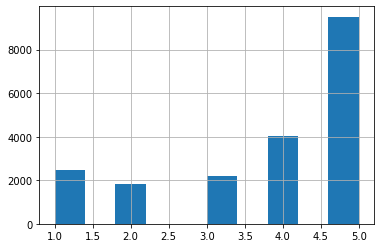

In [11]:
first_reviews["rating"].hist() ### FILL THE BLANK ###

In [12]:
first_reviews["rating"].value_counts() / len(first_reviews)

5.0    0.47530
4.0    0.20155
1.0    0.12275
3.0    0.10955
2.0    0.09085
Name: rating, dtype: float64

This dataset is imbalanced, having ~50% of the dataset with rating = 5. The purpose of this notebook is not about validation metrics, but if we were to use accuracy, we should think about remediation strategy (e.g. subsampling the majority class). This imbalance issue could be one of the improvement axis for the homework.


**Question** : plot the distribution of the number of sentences per review. <br>
When handling sequential/textual data, input length may differ from a review to another. In Deep Learning, knowing input length distribution is important to perform zero-padding or truncating processing.

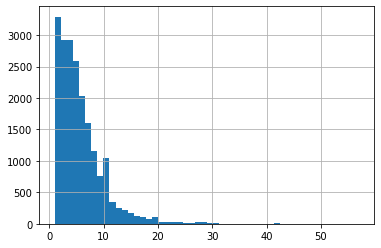

In [13]:
first_reviews["review_sentences"].apply(len).hist(bins=50) ### FILL THE BLANK ###

In [14]:
sentences = list(itertools.chain(*first_reviews["review_sentences"]))
print(f"Number of total sentences : {len(sentences)}")

Number of total sentences : 116654


### Tokenization & Text Encoding
This part concerns tokenization and text encoding with TensorFlow modules :

*(i) Build the token vocabulary* <br>
*(ii) Build a text encoder relying each word to an index, and thus each text to a sequence of word indices* (```list```) <br>
*(iii) Build a TensorFlow dataset for word2vec training*



In [15]:
# Define and fit tokenizer
tokenizer = tf.keras.preprocessing.text.Tokenizer(filters=' ', char_level=False)
tokenizer.fit_on_texts(sentences)

**Question** : use *texts_to_sequences* method of our tokenizer to get sequences from sentences.

In [16]:
sequences = tokenizer.texts_to_sequences(sentences) ### FILL THE BLANK ###
print(first_reviews["review_sentences"][0][0], sentences[0], sequences[0], sep="\n\n")

We actually visited this place a few times for lunch since it opened and it was fine.

We actually visited this place a few times for lunch since it opened and it was fine.

[6, 427, 116, 19, 55, 3, 134, 195, 9, 99, 361, 10, 1009, 2, 10, 4, 1307]


**Question** : plot the distribution of the number of indices per sequence. <br>
For the same reasons as above, it is important to know length distribution of sentences/sequences.

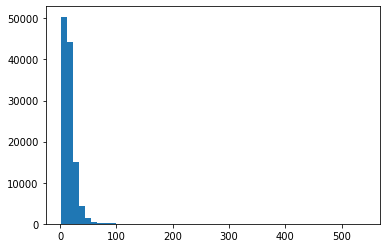

In [17]:
# Check the distribution of the number of indices per sequence
plt.hist([len(sequence) for sequence in sequences], bins=50); ### FILL THE BLANK ###
plt.show()

# 1. Train our own word embeddings 

## Negative Sampling Skipgram
Preprocessing function which generates skip-gram pairs with negative sampling for a list of sequences (int-encoded sentences) based on window size, number of negative samples and (tokenizer) vocabulary size.

In [18]:
max(tokenizer.index_word.keys())

60005

## Generate training data for word2vec

*(i) Define a sampling table for words in vocabulary, see [make_sampling_table](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/sequence/make_sampling_table)* <br>
*(ii) For each sequence (tokenized/indexed sentence), run sliding process (window) and appropriate word sampling to build positive skip-gram word pairs* <br>
*(iii) Iterate over each positive skip-gram pair to produce training examples with positive context word and negative samples, building corresponding labels.* <br>
*(iv) Returns overall combinations of (target word, context word, negative words)*

In [19]:

def generate_training_data(sequences, window_size, num_ns, vocab_size, seed=42):
    # Elements of each training example are appended to these lists.
    targets, contexts, labels = [], [], []

    # Build the sampling table for vocab_size tokens.
    sampling_table = tf.keras.preprocessing.sequence.make_sampling_table(vocab_size)

    # Iterate over all sequences (sentences) in dataset.
    for sequence in tqdm.notebook.tqdm(sequences):

        # Generate positive skip-gram pairs for a sequence (sentence).
        positive_skip_grams, _ = tf.keras.preprocessing.sequence.skipgrams(
            sequence, 
            vocabulary_size=vocab_size,
            sampling_table=sampling_table,
            window_size=window_size,
            negative_samples=0
        )

        # Iterate over each positive skip-gram pair to produce training examples 
        # with positive context word and negative samples.
        for target_word, context_word in positive_skip_grams:
            context_class = tf.expand_dims(tf.constant([context_word], dtype="int64"), 1)
            negative_sampling_candidates, _, _ = tf.random.log_uniform_candidate_sampler(
                true_classes=context_class,
                num_true=1, 
                num_sampled=num_ns, 
                unique=True, 
                range_max=vocab_size, 
                seed=seed, 
                name="negative_sampling"
            )

            # Build context and label vectors (for one target word)
            negative_sampling_candidates = tf.expand_dims(negative_sampling_candidates, 1)

            context = tf.concat([context_class, negative_sampling_candidates], 0)
            label = tf.constant([1] + [0]*num_ns, dtype="int64")

            # Append each element from the training example to global lists.
            targets.append(target_word)
            contexts.append(context)
            labels.append(label)

    return targets, contexts, labels

**Question** : Build training data using ```window_size=2``` and number of negative samples per positive pair ```num_ns=4```. 

In [20]:
targets, contexts, labels = generate_training_data(
    sequences=sequences, ### FILL THE BLANK ###
    window_size=2, 
    num_ns=4, 
    vocab_size=max(tokenizer.index_word.keys())+1 ### FILL THE BLANK ### vocab size + 1 for padding
)

print(len(targets), len(contexts), len(labels))


1089857 1089857 1089857


In [21]:
targets[0], contexts[0]

(195, <tf.Tensor: shape=(5, 1), dtype=int64, numpy=
 array([[ 134],
        [ 897],
        [  52],
        [7228],
        [ 214]])>)

## Define TensorFlow dataset
Define valid TensorFlow dataset from targets/contexts/labels iterable objects.
Set two parameters : 
* *BUFFER_SIZE*
* *BATCH_SIZE*

*BATCH_SIZE* can be particularly important for making training efficient. Note that *BATCH_SIZE* must be obviously lower than dataset size.

In [22]:
BATCH_SIZE = 1024
BUFFER_SIZE = 10000

dataset = tf.data.Dataset.from_tensor_slices(((targets, contexts), labels))
dataset = dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE, drop_remainder=True)
print(dataset)

<BatchDataset shapes: (((1024,), (1024, 5, 1)), (1024, 5)), types: ((tf.int32, tf.int64), tf.int64)>


Define Skipgram model

In [23]:
class Skipgram(tf.keras.Model):
    """Negative Sampling Skigpram implementation.

    ```python
    w2v = Skipgram(vocab_size=4096, embedding_dim=128)
    ````
    """
    def __init__(self, vocab_size, embedding_dim):
        """Skigpram class constructor.

        Parameters
        ----------
        vocab_size: int.
            Size of the vocabulary.

        embedding_dim: int.
            Dimension of trained word2vec Skipgram embeddings.

        """
        super(Skipgram, self).__init__()
        self.target_embedding = tf.keras.layers.Embedding(
            vocab_size, 
            embedding_dim,
            input_length=1,
            name="w2v_embedding",
        )
        self.context_embedding = tf.keras.layers.Embedding(
            vocab_size, 
            embedding_dim, 
            input_length=4+1, # number of negative samples = 4
            name="context_embedding",
        ) 
        self.dots = tf.keras.layers.Dot(axes=(3,2))
        self.flatten = tf.keras.layers.Flatten()

    def call(self, pair):
        """Model forward method.
        """
        target, context = pair
        we = self.target_embedding(target)
        ce = self.context_embedding(context)
        dots = self.dots([ce, we])
        
        return self.flatten(dots)

Define objective and training

In [24]:
embedding_dim = 128

word2vec = Skipgram(vocab_size=max(tokenizer.index_word.keys())+1, embedding_dim=128)
word2vec.compile(
    optimizer="adam",
    loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
    metrics=["accuracy"]
)

In [25]:
word2vec.fit(dataset, epochs=20)

Epoch 1/20
1064/1064 [==============================] - 138s 127ms/step - loss: 1.5490 - accuracy: 0.3143
Epoch 2/20
1064/1064 [==============================] - 135s 127ms/step - loss: 1.2708 - accuracy: 0.5168
Epoch 3/20
1064/1064 [==============================] - 135s 126ms/step - loss: 1.0662 - accuracy: 0.6141
Epoch 4/20
1064/1064 [==============================] - 134s 126ms/step - loss: 0.9044 - accuracy: 0.6788
Epoch 5/20
1064/1064 [==============================] - 136s 128ms/step - loss: 0.7763 - accuracy: 0.7283
Epoch 6/20
1064/1064 [==============================] - 137s 129ms/step - loss: 0.6747 - accuracy: 0.7669
Epoch 7/20
1064/1064 [==============================] - 137s 128ms/step - loss: 0.5939 - accuracy: 0.7969
Epoch 8/20
1064/1064 [==============================] - 136s 128ms/step - loss: 0.5299 - accuracy: 0.8203
Epoch 9/20
1064/1064 [==============================] - 135s 127ms/step - loss: 0.4780 - accuracy: 0.8394
Epoch 10/20
1064/1064 [=======================

## Word Embeddings & Visualization

word2vec.summary()

In [26]:
pretrained_weights = word2vec.get_layer('w2v_embedding').get_weights()[0]
pretrained_weights.shape

(60006, 128)

Let's now visualize the embedding space, in 2 or 3 dimension. We could use a dimensionality reduction method such as PCA, T-SNE or UMAP.

**Question** : after defining PCA object, use *fit_transform* method to get 3D-reduced vectors of word embeddings for visualization and print explained variance ratio.

In [27]:
def do_pca(pretrained_weights):
    pca = decomposition.PCA(n_components=3)
    reduced_weights = pca.fit_transform(pretrained_weights)
    return pca, reduced_weights

pca, reduced_weights = do_pca(pretrained_weights)
print(reduced_weights.shape)
print(pca.explained_variance_ratio_)

(60006, 3)
[0.05732891 0.05210533 0.04276061]


In [28]:
df_pca = pd.DataFrame(data=reduced_weights, columns=["pca_1", "pca_2", "pca_3"])
df_pca["word"] = ["<pad>"] + list(tokenizer.word_index.keys())

In [29]:
fig = px.scatter_3d(
    df_pca, 
    x="pca_1", 
    y="pca_2", 
    z="pca_3",
    hover_name="word",
    template="plotly_white"
)
fig.update_layout(height=700, width=700)
fig.show()

**Question** : explore visual representations and similarities of pretrained word2vec embeddings using convenient visualizer. <br>
To get a better 3D representation, we can use the [TensorFlow Embedding Projector](https://projector.tensorflow.org/). To do that, we save word2vec embeddings (*vecs.tsv* + *meta.tsv*) as following to load them in the projector :

In [30]:
out_v = io.open('vecs.tsv', 'w', encoding='utf-8')
out_m = io.open('meta.tsv', 'w', encoding='utf-8')

for idx, word in tokenizer.index_word.items():
    
    vec = pretrained_weights[idx] # first idx is 1 : skip 0, it's padding.
    out_m.write(word + "\n")
    out_v.write('\t'.join([str(x) for x in vec]) + "\n")
    
out_v.close()
out_m.close()

## 2. Train a sentiment model 
### Using your pre trained embeddings train a simple rating Classifier

Our learned word embeddings can be used to represent the words of a text and to build a text representation. This text representation will be useful for classifcation.


In [31]:
first_reviews["review_sentences"].shape

(20000,)

In [32]:
' '.join(first_reviews["review_sentences"][0])

"We actually visited this place a few times for lunch since it opened and it was fine. Good food, and staff are nice. We then got take away and it was awful. Late, cold, and trying to resolve the problem meant seven or eight phone calls before they finally refunded 50%. Pretty disappointing as we live locally and have always recommended it to friends etc. Wood street needed a nice bar/restaurant and this place filled a void, but the terrible take out service coupled with how poorly we felt they handled the complaint makes me think twice about going again. Shame, as we've spent a lot of time and money here."

**Question** : use *join* operator to get single string per review from lists in *review_sentences* column then plot the input length distribution of the sequences (tokenized reviews).

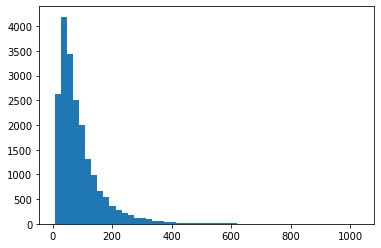

In [33]:
processed_review = [' '.join(rvw) for rvw in first_reviews["review_sentences"]] ### FILL THE BLANK ###
processed_sequences = tokenizer.texts_to_sequences(processed_review)

plt.hist([len(sequence) for sequence in processed_sequences], bins=50)
plt.show()

In [34]:
padded_processed_sequences = tf.keras.preprocessing.sequence.pad_sequences(processed_sequences, maxlen=180, padding="post")
padded_processed_sequences.shape

(20000, 180)

In [35]:
first_reviews.rating.value_counts()

5.0    9506
4.0    4031
1.0    2455
3.0    2191
2.0    1817
Name: rating, dtype: int64

In [36]:
first_reviews['usable_rating'] = first_reviews['rating'].apply(lambda r: int(r)-1)
first_reviews.usable_rating.value_counts()

4    9506
3    4031
0    2455
2    2191
1    1817
Name: usable_rating, dtype: int64

Build datasets

In [37]:
rating_labels = tf.keras.utils.to_categorical(first_reviews['usable_rating'], num_classes=5, dtype='float32')
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(padded_processed_sequences, rating_labels, test_size=0.3)

In [38]:
train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train))
test_ds = tf.data.Dataset.from_tensor_slices((X_test, y_test))

train_ds = train_ds.shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
test_ds = test_ds.batch(BATCH_SIZE)


**Simple rating Model architecture** is defined by :
1. An embedding layer initialized with pretrained word2vec embeddings.
2. A dense layer without particular activation function for linear projection of the previous embedding vectors.
3. A global average pooling (1D).
4. A final dense layer for linear projection in a $d$-dimensional space for sentiment prediction, with $d$ the number sentiments/classes (here 5).


In [39]:
simple_rating_model = tf.keras.Sequential([
    tf.keras.layers.Embedding(
        max(tokenizer.index_word.keys())+1, 
        128, 
        embeddings_initializer=tf.keras.initializers.Constant(pretrained_weights), # weights=[pretrained_weights] 
        trainable=True
    ),
    tf.keras.layers.Dense(64),
    tf.keras.layers.GlobalAveragePooling1D(data_format='channels_last'),
    tf.keras.layers.Dense(5)
])

simple_rating_model.compile(
    loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
    optimizer="adam",
    metrics=["accuracy"]
)

Train model

In [40]:
simple_history = simple_rating_model.fit(
    train_ds, 
    epochs=20, 
    validation_data=test_ds
)

Epoch 1/20
14/14 [==============================] - 3s 177ms/step - loss: 1.5693 - accuracy: 0.3601 - val_loss: 1.4400 - val_accuracy: 0.4732
Epoch 2/20
14/14 [==============================] - 2s 143ms/step - loss: 1.4063 - accuracy: 0.4782 - val_loss: 1.3475 - val_accuracy: 0.4732
Epoch 3/20
14/14 [==============================] - 2s 143ms/step - loss: 1.3226 - accuracy: 0.4831 - val_loss: 1.2957 - val_accuracy: 0.5030
Epoch 4/20
14/14 [==============================] - 2s 146ms/step - loss: 1.2797 - accuracy: 0.5048 - val_loss: 1.2598 - val_accuracy: 0.5065
Epoch 5/20
14/14 [==============================] - 2s 143ms/step - loss: 1.2374 - accuracy: 0.5134 - val_loss: 1.2252 - val_accuracy: 0.5125
Epoch 6/20
14/14 [==============================] - 2s 144ms/step - loss: 1.2053 - accuracy: 0.5215 - val_loss: 1.1859 - val_accuracy: 0.5227
Epoch 7/20
14/14 [==============================] - 2s 144ms/step - loss: 1.1585 - accuracy: 0.5336 - val_loss: 1.1404 - val_accuracy: 0.5335
Epoch 


## 3. Upgrade your sentiment model with attention mechanism through a Hierarchical Attention Network (HAN)

<img src="https://drive.google.com/uc?id=1Q4H1MlBZ6ZasBCHxlARc25T9mBFRctiy"/>
<ID of image>


Preprocessing

For Hierarchical Attention Network, text preprocessing and inputs differ from the previous method. Here, the input is not just a sequence of all integers corresponding to all words/tokens of the review. Working at a sentence-level, the HAN input is a sequence of sequences (tokenized sentences) of integers. 

Thus, a such architecture needs a particular preprocessing (padding and truncating).

In [41]:
def review_preprocessing(review, words_maxlen=50, sentences_maxlen=10, tokenizer=tokenizer):
    """Preprocessing function to build appropriate padded sequences for HAN.

    Parameters
    ----------
    review: list.
        List of sentences (strings) of the review.
    
    words_maxlen: int.
        Maximal length/number of words for a sentence.

    sentences_maxlen: int.
        Maximal length/number of sentences for a review.

    Returns
    -------
    padded_sequences: tf.Tensor.
        Tensor of shape (sentences_maxlen, words_maxlen)
    """
    sequences = tokenizer.texts_to_sequences(review)
    padded_sequences = tf.keras.preprocessing.sequence.pad_sequences(sequences, maxlen=words_maxlen, padding="post")

    if padded_sequences.shape[0] < sentences_maxlen:
        padded_sequences = tf.pad(
            padded_sequences, 
            paddings=tf.constant([[0, sentences_maxlen-padded_sequences.shape[0]], [0, 0]])
        )
    elif padded_sequences.shape[0] > sentences_maxlen:
        padded_sequences = padded_sequences[:sentences_maxlen]

    assert padded_sequences.shape == (sentences_maxlen, words_maxlen)
    return padded_sequences

In [42]:
review_preprocessing(first_reviews["review_sentences"][0]).shape

TensorShape([10, 50])

In [44]:
padded_preprocessed_reviews = [review_preprocessing(review) for review in tqdm.notebook.tqdm(first_reviews["review_sentences"])]
padded_preprocessed_reviews = tf.stack(padded_preprocessed_reviews)
padded_preprocessed_reviews.shape

TensorShape([20000, 10, 50])

Build datasets

In [45]:
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(padded_preprocessed_reviews.numpy(), rating_labels, test_size=0.3)
print(
    X_train.shape,
    X_test.shape, 
    y_train.shape, 
    y_test.shape,
    sep="\n"
)

(14000, 10, 50)
(6000, 10, 50)
(14000, 5)
(6000, 5)


In [46]:
train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train))
test_ds = tf.data.Dataset.from_tensor_slices((X_test, y_test))

train_ds = train_ds.shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
test_ds = test_ds.batch(BATCH_SIZE)

Let's define our Attention Layer

In [47]:
class Attention(tf.keras.layers.Layer):
    """Attention mechanism used in "Hierarchical Attention Networks for Document Classification" paper.
        
    ```python
    attention_layer = Attention(units=64)
    ```
    """
    def __init__(self, units):
        """Attention layer constructor.

        Parameters
        ----------
        units: int.
            Dimension of the projection space.
        """
        super(Attention, self).__init__()
        self.W = tf.keras.layers.Dense(units)
        self.u = tf.keras.layers.Dense(1)

    def call(self, sequence):
        """Layer forward method.
        """
        attention_logits = self.u(tf.nn.tanh(self.W(sequence)))
        attention_weights = tf.nn.softmax(attention_logits)

        weighted_vectors = attention_weights * sequence
        context_vector = tf.reduce_sum(weighted_vectors, axis=-2)

        return context_vector, attention_weights

In [48]:
batch1 = tf.random.normal((16, 10, 50, 128))
batch2 = tf.random.normal((16, 10, 128))

attention = Attention(units=64)

(att_batch1, weights_batch1), (att_batch2, weights_batch2) = attention(batch1), attention(batch2)
print(att_batch1.shape, weights_batch1.shape)
print(att_batch2.shape, weights_batch2.shape)

(16, 10, 128) (16, 10, 50, 1)
(16, 128) (16, 10, 1)


**Hierarchical Attention Network architecture** is defined by:

1. An embedding layer initialized with pretrained word2vec embeddings.
2. A sentence encoder : a Bidirectional GRU coupled with an Attention process run on words embeddings.
3. A document/review encoder : a Bidirectional GRU coupled with an Attention process run on sentence encoder outputs.
4. A final dense layer for linear projection in a $d$-dimensional space for sentiment prediction, with $d$ the number of possible sentiments/classes.


In [52]:
class HierarchicalAttentionNetwork(tf.keras.Model):
    """Hierarchical Attention Network implementation.

    Reference :
    * Hierarchical Attention Networks for Document Classification : https://www.cs.cmu.edu/~./hovy/papers/16HLT-hierarchical-attention-networks.pdf

    """
    def __init__(self, vocab_size, embedding_dim, gru_units, attention_units, classifier_units, pretrained_weights=None):
        """Hierarchical Attention Network class constructor.

        """
        super(HierarchicalAttentionNetwork, self).__init__()
        
        if pretrained_weights is not None:
            initializer = tf.keras.initializers.Constant(pretrained_weights)
        else:
            initializer = "uniform"

        self.embedding = tf.keras.layers.Embedding(
            vocab_size, 
            embedding_dim, 
            embeddings_initializer=initializer,
            trainable=True
        )
        self.WordGRU = tf.keras.layers.Bidirectional(
            tf.keras.layers.GRU(
                units=gru_units,
                activation="tanh",
                return_sequences=True
            ), 
            merge_mode='concat',
        )
        self.WordAttention = Attention(units=attention_units)
        self.SentenceGRU = tf.keras.layers.Bidirectional(
            tf.keras.layers.GRU(
                units=gru_units,
                activation="tanh",
                return_sequences=True
            ), 
            merge_mode='concat',
        )
        self.SentenceAttention = Attention(units=attention_units)
        self.fc = tf.keras.layers.Dense(units=classifier_units)

    def call(self, x):
        """Model forward method.
        """
        sentences_vectors, _ = self.word_to_sentence_encoder(x)
        document_vector, _ = self.sentence_to_document_encoder(sentences_vectors)
        return self.fc(document_vector)

    def word_to_sentence_encoder(self, x):
        """Given words from each sentences, 
           encode the contextual representation of the words from the sentence
           with Bidirectional GRU and Attention, and output a sentence_vector
        """
        x = self.embedding(x)
        x = tf.keras.layers.TimeDistributed(self.WordGRU)(x)
        context_vector, attention_weights = self.WordAttention(x)

        return context_vector, attention_weights
    
    def sentence_to_document_encoder(self, sentences_vectors):
        sentences_vectors = self.SentenceGRU(sentences_vectors)
        document_vector, attention_weights = self.SentenceAttention(sentences_vectors)
        return document_vector, attention_weights

In [53]:
han_model = HierarchicalAttentionNetwork(
    vocab_size=max(tokenizer.index_word.keys())+1, 
    embedding_dim=128, 
    pretrained_weights=pretrained_weights, 
    gru_units=32, 
    attention_units=32, 
    classifier_units=5
)

In [54]:
test_batch = tf.zeros((256, 10, 50))
test_output = han_model(test_batch)
test_output.shape

TensorShape([256, 5])

In [55]:
han_model.compile(
    loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
    optimizer="adam",
    metrics=["accuracy"]
)

In [56]:
han_history = han_model.fit(
    train_ds, 
    epochs=20, 
    validation_data=test_ds
)

Epoch 1/20
14/14 [==============================] - 12s 435ms/step - loss: 5.2321 - accuracy: 0.3280 - val_loss: 2.3471 - val_accuracy: 0.3747
Epoch 2/20
14/14 [==============================] - 5s 345ms/step - loss: 1.9780 - accuracy: 0.4229 - val_loss: 1.5548 - val_accuracy: 0.4662
Epoch 3/20
14/14 [==============================] - 5s 350ms/step - loss: 1.3903 - accuracy: 0.5041 - val_loss: 1.3398 - val_accuracy: 0.4988
Epoch 4/20
14/14 [==============================] - 5s 347ms/step - loss: 1.1635 - accuracy: 0.5518 - val_loss: 1.2348 - val_accuracy: 0.5172
Epoch 5/20
14/14 [==============================] - 5s 349ms/step - loss: 1.0357 - accuracy: 0.6012 - val_loss: 1.1791 - val_accuracy: 0.5400
Epoch 6/20
14/14 [==============================] - 5s 347ms/step - loss: 0.9346 - accuracy: 0.6376 - val_loss: 1.1457 - val_accuracy: 0.5558
Epoch 7/20
14/14 [==============================] - 5s 345ms/step - loss: 0.8553 - accuracy: 0.6674 - val_loss: 1.1260 - val_accuracy: 0.5580
Epoch

*Conclusion* :
* The simple model is a good baseline
* HAN model is much more heavy, with stronger and powerful learning capabilities for training data, involving overfitting risk. Thus it needs regularization (e.g. dropout for instance) for generalization.

## Some improvements for hands-on and homework
**Consider some (1 or 2) of these suggestions to improve HAN performances** :
* Regularization for generalization : dropout, recurrent dropout, L2/L1 regularization
* Address unbalacanced data problems : 
  * For training : oversampling, subsampling, loss weighting, new loss function ?
  * For evaluation : consider other metrics than accuracy : precision, recall, f1-score, confusion matrix...
* Aggressive padding strategy : introduce masking ?
* Iterate with more data, including more validation data

# 4. Visualize attention weights to interpet main sentences and words involved in the prediction

**Question** : add a new ```document_encoder``` method in HierarchicalAttentionNetwork model which output the document vector and attention weights (sentences weighting) from preprocessed review to determine the most importance sentences. 

**Bonus** : get word attention weights for each sentence of a review to show the important words of important sentences.